# 고혈압 분석 모델

고혈압 판단 조건
1. 'AS1_BPLIE2S_A' 누운 자세 - 2회 sys 측정 평균 140 이상
2. 'AS1_BPLIE2D_A',누운 자세 - 2회 dia 측정 평균 90 이상
3. 'AS1_DrugHtCu' 2번 응답

## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

- 17차
  - 2022-05-04
  - _1000 변수만으로 모델 학습

- 18차
  - 2022-05-13
  - 혈압을 예측하는 회귀모델 구현
  - _1000 변수 + 원래 쓰던거
  - 77777 to 0
    - AS1_DRDUA: 77777 to 0
    - AS1_HVSMAM: 77777 to 0

  - 그냥 삭제
    - 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 전처리

### 데이터 불러오기

In [2]:
# dataset = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/dataset220513_5.xlsx',
#                       index_col=0, na_values=[77777, 99999, '#NULL!','#DIV/0!', 'NA', ' '])

### 결측값 제거

- AS1_TOTALC
- AS1_FMHTREL1A
- AS1_FMDMREL1A
- AS1_FMHEREL1A
- AS1_FMCVAREL1A
- AS1_FMCDREL1A
- AS1_FMCDREL1AG
- AS1_FMCHREL1A
- AS1_FMPVREL1A
- AS1_FMLPREL1A

In [3]:
# dataset.drop(columns=['AS1_TOTALC', 'AS1_FMHTREL1A', 'AS1_FMDMREL1A',
#                       'AS1_FMHEREL1A', 'AS1_FMCVAREL1A', 'AS1_FMCDREL1AG',
#                       'AS1_FMCDREL1A', 'AS1_FMCHREL1A', 'AS1_FMPVREL1A',
#                       'AS1_FMLPREL1A', 'AS1_DRUGHTCU'], inplace=True)

In [4]:
# dataset.dropna(subset=['AS1_BPLIE2S_A', 'AS1_BPLIE2D_A'], inplace=True)
# dataset['HYPERTENSION'] = np.where((dataset['AS1_DRUGHTCU_FILLNA'] == 2) | (dataset['AS1_BPLIE2S_A'] >= 140) | (dataset['AS1_BPLIE2D_A'] >= 90), 2, 1)

In [5]:
# condition = [(dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 60),  # 60대 남자
#              (dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 50),  # 50대 남자
#              (dataset['AS1_SEX'] == 1 ) & (dataset['AS1_AGE'] >= 40),  # 40대 남자
#              (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 60),  # 60대 여자
#              (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 50),  # 50대 여자
#              (dataset['AS1_SEX'] == 2 ) & (dataset['AS1_AGE'] >= 40)   # 40대 여자
#             ]
# choice = ['M60', 'M50', 'M40', 'F60', 'F50', 'F40']

# dataset['group'] = np.select(condition, choice, default=np.nan)

# fill_mean_func = lambda g: g.fillna(g.mean()) # 각 그룹별 평균으로 결측값 대치

# dataset['AS1_HEIGHT'] = dataset.groupby('group')['AS1_HEIGHT'].apply(fill_mean_func)
# dataset['AS1_WEIGHT'] = dataset.groupby('group')['AS1_WEIGHT'].apply(fill_mean_func)

In [6]:
# dataset['AS1_BMI'] = np.where(pd.notnull(dataset['AS1_BMI']) == True, # null이 아니면?
#                               dataset['AS1_BMI'],  # 원래 값 그대로 
#                               dataset['AS1_WEIGHT'] / ((dataset['AS1_HEIGHT']/100) ** 2)) # 아니면 bmi 계산

In [7]:
# dataset.dropna(inplace=True)

### dataset 스케일링

In [8]:
# # dataset에 있는 변수 분리
# # 범주형, 연속형 등으로 분리하여 raw_var 형태로 저장하여 각각 관리한다.

# # 종속변수
# label = dataset.reindex(columns=['AS1_DRUGHTCU_FILLNA', 'AS1_BPLIE2S_A', 'AS1_BPLIE2D_A', 'HYPERTENSION'])

# # 범주형(binary, 0 or 1)
# raw_binary = dataset.reindex(columns=['AS1_SEX', 'AS1_STRPHYSJ'])
# raw_binary['AS1_SEX'] -= 1
# col_b = raw_binary.columns

# # 범주형(계층 없음, without hierarchy)
# raw_categoryH0 = dataset.reindex(columns=['AS1_DRINK', 'AS1_SMOKEA'])
# col_H0 = raw_categoryH0.columns

# # 범주형(계층 있음, with hierarchy)
# raw_categoryH1 = dataset.reindex(columns=['AS1_EDUA', 'AS1_INCOME', 'AS1_DRDUA',
#                                           'AS1_PHYSTB', 'AS1_PHYSIT', 'AS1_PHYACTL',
#                                           'AS1_PHYACTM', 'AS1_PHYACTH', 'AS1_HEALTH'
#                                           ])
# col_H1 = raw_categoryH1.columns

# # 연속형 변수
# raw_ctn = dataset.reindex(columns=['AS1_AGE', 'AS1_HVSMAM', 'AS1_HVSMDU', 'AS1_SLPAMTM',
#                                    'AS1_RGMEALFQA', 'AS1_HEIGHT', 'AS1_WEIGHT',
#                                    'AS1_WAIST3_A', 'AS1_BMI', 'AS1_B01',
#                                    'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                                    'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                                    'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                                    'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                                    'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                                    'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                                    'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                                    'AS1_B24_1000',
#                                   #  'DP1', 'DP2', 'DP3', 'DP4', 'DP5',
#                                    'FA1', 'FA2', 'FA3', 'FA4', 'FA5'
#                                    ])
# col_c = raw_ctn.columns

In [9]:
# from sklearn.preprocessing import QuantileTransformer

# def quantile(categoryH1, ctn):
#   categoryH1[col_H1] = QuantileTransformer().fit_transform(categoryH1)
#   ctn[col_c] = QuantileTransformer().fit_transform(ctn)

#   return categoryH1, ctn

In [10]:
# from sklearn.preprocessing import QuantileTransformer

# categoryH0 = pd.get_dummies(raw_categoryH0, columns=col_H0, drop_first=True) # one-hot-encoding
# categoryH1 = pd.DataFrame(QuantileTransformer().fit_transform(raw_categoryH1), index=dataset.index, columns=col_H1).astype('float')
# ctn = pd.DataFrame(QuantileTransformer().fit_transform(raw_ctn), index=dataset.index, columns=col_c).astype('float')

## dataset 분리
- train, test

In [11]:
# X = pd.concat([raw_binary, categoryH0, categoryH1, ctn], axis=1)
# raw_y = pd.DataFrame(QuantileTransformer().fit_transform(label), index=dataset.index, columns=label.columns)

In [12]:
# X.to_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/ScaledDataset.pkl')
# raw_y.to_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/ScaledLabel.pkl')

In [13]:
X = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/ScaledDataset.pkl')
raw_y = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/ScaledLabel.pkl')

In [33]:
# y = raw_y['AS1_DRUGHTCU_FILLNA']
# y = raw_y['AS1_BPLIE2S_A']
# y = raw_y['AS1_BPLIE2D_A']
y = raw_y['HYPERTENSION']

display(y)

RID
EPI20_026_2_000004    1.0
EPI20_026_2_000006    1.0
EPI20_026_2_000007    0.0
EPI20_026_2_000010    0.0
EPI20_026_2_000011    1.0
                     ... 
EPI20_026_2_010024    0.0
EPI20_026_2_010026    0.0
EPI20_026_2_010028    0.0
EPI20_026_2_010029    0.0
EPI20_026_2_010030    1.0
Name: HYPERTENSION, Length: 8149, dtype: float64

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6519, 53) (1630, 53) (6519,) (1630,)


## 모델 제작 XGBoost Classifiaction

HYPERTENSION 0 / 1

In [16]:
import xgboost as xgb
from xgboost import plot_importance

In [37]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [40]:
dtrain.feature_types

['int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'int',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float',
 'float']

In [27]:
# Define hyperparameters
params_xgb = {"max_depth": 5,
              "eta": 0.1,
              'objective': 'binary:logistic',
              'eval_metric':'logloss',
              'early_stopping': 32
              }

num_round = 400

### train()

In [41]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=num_round, evals=wlist)
xgb_model

[0]	train-logloss:0.655889	eval-logloss:0.658221
[1]	train-logloss:0.625536	eval-logloss:0.629508
[2]	train-logloss:0.600092	eval-logloss:0.605999
[3]	train-logloss:0.578416	eval-logloss:0.586562
[4]	train-logloss:0.559924	eval-logloss:0.569878
[5]	train-logloss:0.543983	eval-logloss:0.556703
[6]	train-logloss:0.530405	eval-logloss:0.544947
[7]	train-logloss:0.518586	eval-logloss:0.535038
[8]	train-logloss:0.508226	eval-logloss:0.526917
[9]	train-logloss:0.498936	eval-logloss:0.519856
[10]	train-logloss:0.49096	eval-logloss:0.514365
[11]	train-logloss:0.483995	eval-logloss:0.50973
[12]	train-logloss:0.477795	eval-logloss:0.505548
[13]	train-logloss:0.472322	eval-logloss:0.502214
[14]	train-logloss:0.466613	eval-logloss:0.498806
[15]	train-logloss:0.461661	eval-logloss:0.496491
[16]	train-logloss:0.457144	eval-logloss:0.494942
[17]	train-logloss:0.453301	eval-logloss:0.493522
[18]	train-logloss:0.449008	eval-logloss:0.491093
[19]	train-logloss:0.445201	eval-logloss:0.489458
[20]	train-l

### predict()

In [43]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

[0.297 0.311 0.03  0.069 0.018 0.004 0.083 0.17  0.124 0.162]


In [44]:
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [46]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  cf = confusion_matrix(y_test, pred)
  acc = accuracy_score(y_test, pred)
  prc = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)

  print(cf)
  print(f"""
  정확도 {format(acc, '.4f')}
  정밀도 {format(prc, '.4f')}
  재현율 {format(recall, '.4f')}
  F1     {format(f1, '.4f')}
  AUC    {format(roc_auc, '.4f')}
  """)

In [47]:
get_clf_eval(y_test, preds, pred_probs)

[[1167   91]
 [ 317   55]]

  정확도 0.7497
  정밀도 0.3767
  재현율 0.1478
  F1     0.2124
  AUC    0.6688
  


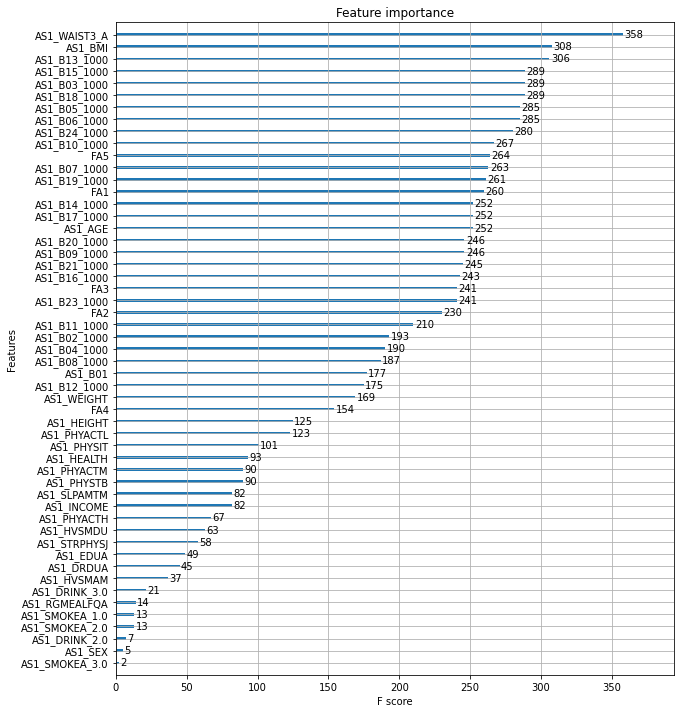

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## 모델 제작 XGBoost Regression
https://www.kaggle.com/code/harvindarjunrai/predicting-house-prices-v1/notebook

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Define a function for each metric
# R²
def rsqr_score(test, pred):
    """Calculate R squared score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score 
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred, model):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {model}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [ ]:
# Define hyperparameters
tuned_parameters_xgb = {"max_depth": [3],
                        "colsample_bytree": [0.3, 0.7],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [100, 500, 1000]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters_xgb,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[18:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Best R²: 0.19239226561742367


In [ ]:
model_xgb_opt = XGBRegressor(colsample_bytree = xgbr_cv.best_params_["colsample_bytree"],
                             learning_rate = xgbr_cv.best_params_["learning_rate"],
                             max_depth = xgbr_cv.best_params_["max_depth"],
                             n_estimators = xgbr_cv.best_params_["n_estimators"])

model_xgb_opt.fit(X_train, y_train)
y_pred_xgb_opt = model_xgb_opt.predict(X_test)
print_score(y_test, y_pred_xgb_opt, "XGBoost")

[18:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
- Regressor: XGBoost
R²: 0.23443704727259929
RMSE: 0.25175056594755973



## 모델 제작 다항 회귀
Polynomial Regression

In [ ]:
# PolynomialFeatures 클래스를 이용해 피처를 다항식 피처로 변환
from sklearn.preprocessing import PolynomialFeatures

# degree = 2 인 2차 다항식으로 X를 변환
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

print('일차 단항식 계수 피처 : ', X)
print('변환된 2차 다항식 계수 피처 : ', X_poly[0])

## 모델 제작 DNN

In [ ]:
UNITS = 32
EPOCH = 64
DROPOUT = 0.05
LEARNINGRATE = 0.01

In [ ]:
# class ClearTrainingOutput(keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [ ]:
# 모델 생성 - 함수
def create_model():
  model_dnn = Sequential()

  model_dnn.add(Dense(units=UNITS, activation='relu'))  # input

  model_dnn.add(Dropout(DROPOUT))
  model_dnn.add(Dense(units=UNITS, activation='relu'))

  model_dnn.add(Dropout(DROPOUT))
  model_dnn.add(Dense(units=UNITS, activation='relu'))

  model_dnn.add(Dropout(DROPOUT))
  model_dnn.add(Dense(units=UNITS, activation='relu'))

  model_dnn.add(Dense(units=1))  # output

  return model_dnn

In [ ]:
model_dnn = create_model()
model_dnn.compile(optimizer=Adam(learning_rate=LEARNINGRATE), loss='mse', metrics=['accuracy'])
history = model_dnn.fit(X_train, y_train, epochs=EPOCH, validation_split=0.2, callbacks=es)

Epoch 1/64
163/163 [==============================] - 1s 4ms/step - loss: 0.0783 - accuracy: 3.8351e-04 - val_loss: 0.0732 - val_accuracy: 7.6687e-04
Epoch 2/64
163/163 [==============================] - 0s 3ms/step - loss: 0.0738 - accuracy: 3.8351e-04 - val_loss: 0.0700 - val_accuracy: 7.6687e-04
Epoch 3/64
163/163 [==============================] - 0s 3ms/step - loss: 0.0699 - accuracy: 1.9175e-04 - val_loss: 0.0819 - val_accuracy: 7.6687e-04
Epoch 4/64
163/163 [==============================] - 0s 3ms/step - loss: 0.0700 - accuracy: 1.9175e-04 - val_loss: 0.0700 - val_accuracy: 7.6687e-04
Epoch 5/64
163/163 [==============================] - 1s 3ms/step - loss: 0.0691 - accuracy: 1.9175e-04 - val_loss: 0.0693 - val_accuracy: 7.6687e-04
Epoch 6/64
163/163 [==============================] - 0s 3ms/step - loss: 0.0685 - accuracy: 1.9175e-04 - val_loss: 0.0686 - val_accuracy: 7.6687e-04
Epoch 7/64
163/163 [==============================] - 1s 3ms/step - loss: 0.0692 - accuracy: 1.9175e

In [ ]:
print(history.history)

{'loss': [0.07939421385526657, 0.07223104685544968, 0.07000595331192017, 0.07100877165794373, 0.07008271664381027, 0.06818887591362, 0.06820348650217056, 0.06881190091371536, 0.06943759322166443, 0.06790866702795029, 0.06851641088724136, 0.06729327887296677, 0.06749797612428665, 0.0674222856760025, 0.06846547871828079, 0.06857617199420929], 'accuracy': [0.0003835091192740947, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735, 0.0003835091192740947, 0.00019175455963704735, 0.0003835091192740947, 0.00019175455963704735, 0.00019175455963704735, 0.00019175455963704735], 'val_loss': [0.06976764649152756, 0.06892088800668716, 0.06966207921504974, 0.07166914641857147, 0.07437621802091599, 0.0678953230381012, 0.07973921298980713, 0.06848450750112534, 0.06982365995645523, 0.07064735889434814, 0.071185402572155, 0.07027660310268402, 

In [ ]:
history.history

In [ ]:
model_dnn.summary()
y_pred = model_dnn.predict(X_test).flatten()
acc = model_dnn.evaluate(X_test, y_test)
print('test_loss: ', acc)
# print('test_mae: ',test_acc)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 32)                1728      
                                                                 
 dropout_30 (Dropout)        (None, 32)                0         
                                                                 
 dense_51 (Dense)            (None, 32)                1056      
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 32)                1056      
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_53 (Dense)            (None, 32)              

## 모델 제작 CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [ ]:
EPOCH = 128
DROPOUT = 0.05
LEARNINGRATE = 0.01
i = 8

embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.05 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 16 # 뉴런의 수

In [ ]:
embedding_dim = 8 # 임베딩 벡터의 차원
dropout_ratio = 0.05 # 드롭아웃 비율
num_filters = 8 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 64 # 뉴런의 수

model = Sequential()

model.add(Embedding(len(X_train), embedding_dim))
model.add(Dropout(dropout_ratio))

model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/100
243/243 [==============================] - ETA: 0s - loss: 0.1910 - acc: 0.7608
Epoch 1: val_acc improved from -inf to 0.77846, saving model to best_model.h5
243/243 [==============================] - 14s 8ms/step - loss: 0.1910 - acc: 0.7608 - val_loss: 0.1745 - val_acc: 0.7785
Epoch 2/100
242/243 [============================>.] - ETA: 0s - loss: 0.1830 - acc: 0.7602
Epoch 2: val_acc did not improve from 0.77846
243/243 [==============================] - 2s 7ms/step - loss: 0.1829 - acc: 0.7605 - val_loss: 0.1736 - val_acc: 0.7785
Epoch 3/100
239/243 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.7601
Epoch 3: val_acc did not improve from 0.77846
243/243 [==============================] - 2s 8ms/step - loss: 0.1827 - acc: 0.7605 - val_loss: 0.1725 - val_acc: 0.7785
Epoch 4/100
243/243 [==============================] - ETA: 0s - loss: 0.1824 - acc: 0.7605
Epoch 4: val_acc did not improve from 0.77846
243/243 [==============================] - 2s 7ms/st

In [ ]:
model.summary()
model.evaluate(X_test, y_test)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 8)           62104     
                                                                 
 dropout_7 (Dropout)         (None, None, 8)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, None, 8)           200       
                                                                 
 global_max_pooling1d_3 (Glo  (None, 8)                0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                576       
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                      

[0.17405691742897034, 0.7784647345542908]

In [ ]:
EPOCH = 64
DROPOUT = 0.05
LEARNINGRATE = 0.01
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.05 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 16 # 뉴런의 수

def model_builder(hp):
  model = Sequential()
  hp_units = hp.Int('units', min_value = 4, max_value = EPOCH, step = 4)
  hp_dropout = hp.Float('dropout', min_value=0.0, max_value=0.5, default=0.05, step=0.05)
  hp_emb_dim = hp.Int('embedding_dim', min_value = 64, max_value = 512, step = 64)
  hp_filters = hp.Int('filters', min_value = 8, max_value = 5)

  model.add(Embedding(len(X_train), embedding_dim))
  model.add(Dropout(dropout_ratio))

  model.add(Conv1D(hp_filters, kernel_size, padding='valid', activation='relu'))
  model.add(GlobalMaxPooling1D())
  
  model.add(Dropout(hp_dropout))
  model.add(Dense(units = hp_units, activation='relu'))

  model.add(Dropout(hp_dropout))
  model.add(Dense(1, activation='sigmoid')) # 출력층

  # Tune the learning rate for the optimizer S
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3]) # 0.01 or 0.001

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                # loss="binary_crossentropy", # 손실함수: binary_crossentropy
                loss='mse'
                # metrics = ['accuracy']
                ) # 평가지표

  # model.compile(optimizer='rmsprop', 
  #               loss='mse', metrics=['mse']) #손실함수: MSE(mean squared error)
  
  return model

In [ ]:
# input_shape = (X_train.shape[1],)
# hypermodel = RegressionHyperModel(input_shape)

tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = EPOCH,
                     hyperband_iterations = EPOCH,
                     directory = '/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns',
                     project_name = '0507_2')

tuner.search(X_train, y_train,
             epochs = EPOCH,
             validation_split=0.2,
             callbacks = [ClearTrainingOutput(), es, mc])

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
//하이퍼 파라미터 검색 완료//
최적의 은닉층 unit 수는
{best_hps.get('units')}
최적의 학습률은
{best_hps.get('learning_rate')}
최적의 드롭아웃 확률은
{best_hps.get('dropout')}.
""")

In [ ]:
model = tuner.hypermodel.build(best_hps)
scores = model.evaluate(X_test, y_test)
print("%s: %.2f, %s: %.2f%%" % (model.metrics_names[0], scores[0], model.metrics_names[1], scores[1] * 100))

## 변수 중요도

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb)